# 💊 Drug Classification

## Preprocessing

* Dropping Duplicates, infinities and NaNs

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("Dataset/final/dataset.csv")

df.drop_duplicates(inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

x = df.drop(columns=["label"])
y = df["label"]

print(f"✅ Shape:       {x.shape}, Labels: {y.shape}")

✅ Shape:       (1717, 2048), Labels: (1717,)


#### Random Oversampling

In [2]:
from imblearn.over_sampling import RandomOverSampler

# Oversample only training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x, y)

print(f"✅ After Oversampling: {x_ros.shape}, Labels: {y_ros.shape}")
print(y_ros.value_counts())


✅ After Oversampling: (3562, 2048), Labels: (3562,)
label
2     274
9     274
10    274
0     274
6     274
11    274
3     274
1     274
7     274
4     274
5     274
8     274
12    274
Name: count, dtype: int64


#### Class Distribution

🔢 Full Dataset — Total: 1717
  Class 0: 184 (10.72%)
  Class 1: 51 (2.97%)
  Class 2: 195 (11.36%)
  Class 3: 139 (8.10%)
  Class 4: 102 (5.94%)
  Class 5: 42 (2.45%)
  Class 6: 208 (12.11%)
  Class 7: 174 (10.13%)
  Class 8: 68 (3.96%)
  Class 9: 274 (15.96%)
  Class 10: 42 (2.45%)
  Class 11: 116 (6.76%)
  Class 12: 122 (7.11%)

🔢 Balanced Dataset — Total: 3562
  Class 0: 274 (7.69%)
  Class 1: 274 (7.69%)
  Class 2: 274 (7.69%)
  Class 3: 274 (7.69%)
  Class 4: 274 (7.69%)
  Class 5: 274 (7.69%)
  Class 6: 274 (7.69%)
  Class 7: 274 (7.69%)
  Class 8: 274 (7.69%)
  Class 9: 274 (7.69%)
  Class 10: 274 (7.69%)
  Class 11: 274 (7.69%)
  Class 12: 274 (7.69%)



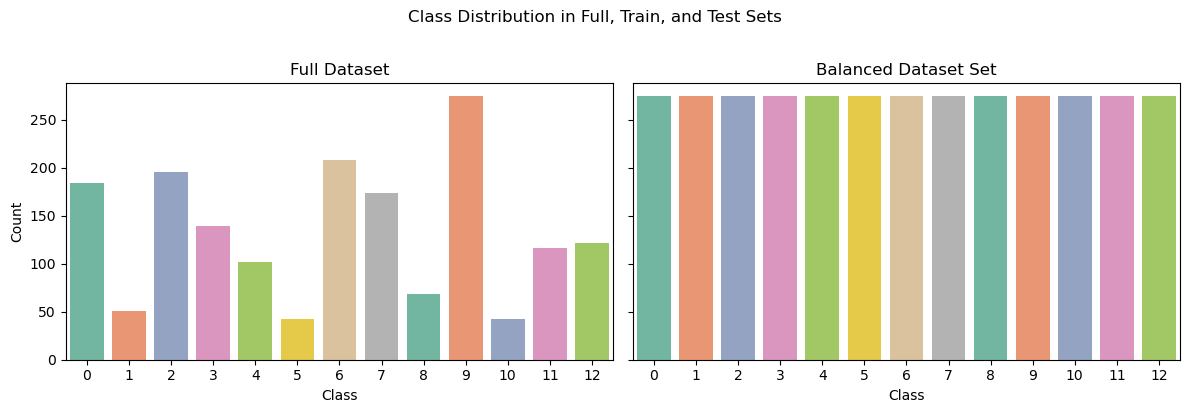

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine y with x for plotting
train_df = x_ros.copy()
train_df["label"] = y_ros.values

# --- Print Class Ratios ---
def print_class_ratios(name, series):
    value_counts = series.value_counts()
    total = len(series)
    print(f"🔢 {name} — Total: {total}")
    for label in sorted(value_counts.index):
        count = value_counts[label]
        pct = 100 * count / total
        print(f"  Class {label}: {count} ({pct:.2f}%)")
    print()

print_class_ratios("Full Dataset", df["label"])
print_class_ratios("Balanced Dataset", train_df["label"])

# --- Plot Class Distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Full Dataset
sns.countplot(data=df, x="label", hue="label", palette="Set2", legend=False, ax=axes[0])
axes[0].set_title("Full Dataset")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# Train Set
sns.countplot(data=train_df, x="label", hue="label", palette="Set2", legend=False, ax=axes[1])
axes[1].set_title("Balanced Dataset Set")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("")

# Tidy up
plt.suptitle("Class Distributions", y=1.02)
plt.tight_layout()
plt.show()


### 🔁 Cross-Validation

We perform 5-fold cross-validation to estimate the model's generalization performance. F1-Macro is used as the scoring metric.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, top_k_accuracy_score, f1_score
import numpy as np

penalty = 'l2'
solver = 'saga'
class_weight = None
max_iter = 20000
random_state = 42
Cs = [0.01, 0.1, 1, 10]

# ------------------ CV Pipeline ------------------
pipeline_cv = Pipeline([
    ('vt', VarianceThreshold(threshold=0)),
    ('clf', LogisticRegressionCV(
        Cs=Cs,
        penalty=penalty,
        solver=solver,
        scoring='f1_macro',
        max_iter=max_iter,
        cv=5,
        n_jobs=-1,
        verbose=3,
        random_state=random_state,
        class_weight=class_weight
    ))
])

pipeline_cv.fit(x_ros, y_ros)

best_C = pipeline_cv.named_steps['clf'].C_[0]
print(f"\n✅ Best C: {best_C}")

# ------------------ Final Pipeline ------------------
pipeline = Pipeline([
    ('vt', VarianceThreshold(threshold=0)),
    ('clf', LogisticRegression(
        C=best_C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        random_state=random_state,
        class_weight=class_weight
    ))
])

# ------------------ Cross-Val Prediction ------------------
y_proba_cv = cross_val_predict(
    pipeline, x_ros, y_ros,
    method='predict_proba',
    cv=5,
    n_jobs=-1,
    verbose=3
)
y_pred_cv = np.argmax(y_proba_cv, axis=1)

metrics = {
    'Accuracy': accuracy_score(y_ros, y_pred_cv),
    'Top_3': top_k_accuracy_score(y_ros, y_proba_cv, k=3),
    'Top_5': top_k_accuracy_score(y_ros, y_proba_cv, k=5),
    'f1_macro': f1_score(y_ros, y_pred_cv, average='macro'),
    'f1_weighted': f1_score(y_ros, y_pred_cv, average='weighted')
}


# ------------------ Evaluation ------------------
print("\n✅ Cross-validated Training Performance:")
print("Accuracy:", metrics['Accuracy'])
print("Top-3 Accuracy:", metrics['Top_3'])
print("Top-5 Accuracy:", metrics['Top_5'])
print("F1 Macro:", metrics['f1_macro'])
print("F1 Weighted:", metrics['f1_weighted'])

print("\n📊 Classification Report:")
print(classification_report(y_ros, y_pred_cv, digits=3))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


convergence after 57 epochs took 8 seconds
convergence after 57 epochs took 8 seconds
convergence after 58 epochs took 8 seconds
convergence after 59 epochs took 8 seconds
convergence after 62 epochs took 9 seconds
convergence after 126 epochs took 28 seconds
convergence after 132 epochs took 29 seconds
convergence after 132 epochs took 29 seconds
convergence after 126 epochs took 29 seconds
convergence after 129 epochs took 30 seconds
convergence after 300 epochs took 58 seconds
convergence after 342 epochs took 63 seconds
convergence after 347 epochs took 63 seconds
convergence after 351 epochs took 65 seconds
convergence after 350 epochs took 64 seconds
convergence after 659 epochs took 96 seconds
convergence after 940 epochs took 136 seconds


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.9min remaining:  5.9min


convergence after 949 epochs took 139 seconds
convergence after 966 epochs took 140 seconds
convergence after 974 epochs took 142 seconds


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished


convergence after 603 epochs took 109 seconds

✅ Best C: 10.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min



✅ Cross-validated Training Performance:
Accuracy: 0.744806288601909
Top-3 Accuracy: 0.9090398652442448
Top-5 Accuracy: 0.9562043795620438
F1 Macro: 0.7393103448335621
F1 Weighted: 0.739310344833562

📊 Classification Report:
              precision    recall  f1-score   support

           0      0.699     0.602     0.647       274
           1      0.849     0.945     0.895       274
           2      0.749     0.642     0.692       274
           3      0.566     0.529     0.547       274
           4      0.789     0.832     0.810       274
           5      0.814     0.993     0.895       274
           6      0.758     0.653     0.702       274
           7      0.847     0.770     0.807       274
           8      0.849     0.964     0.903       274
           9      0.687     0.544     0.607       274
          10      0.869     0.967     0.915       274
          11      0.648     0.726     0.685       274
          12      0.500     0.515     0.507       274

    accuracy     

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


#### Tuning used in the Logistic Regression Model

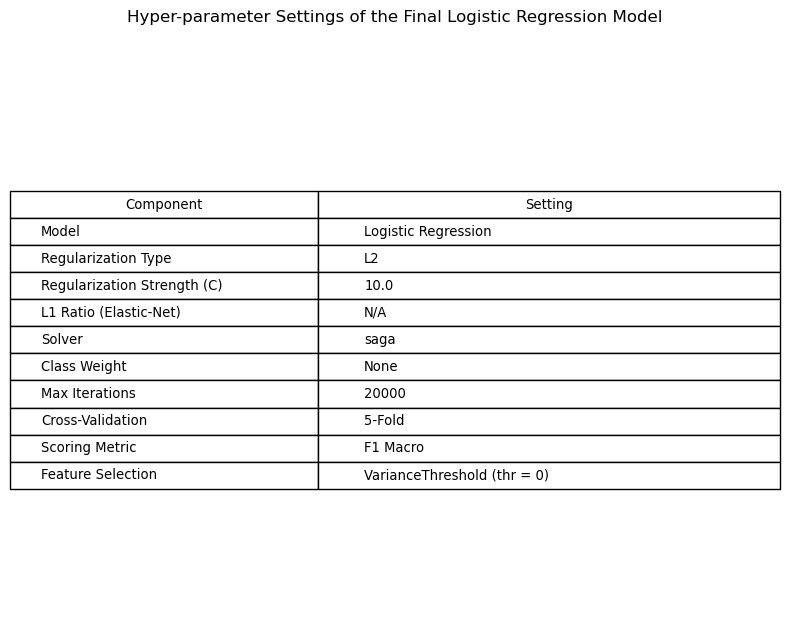

In [ ]:
import matplotlib.pyplot as plt

# ── Extract components from pipeline ─────────────────────────
vt = pipeline.named_steps['vt']
final_model = pipeline.named_steps['clf']
# ------------------------------------------------------------

# ---------- extract settings ----------
penalty        = final_model.penalty.upper()                     # 'L1' or 'ELASTICNET'
C_value        = final_model.C                                  # best C (float)
solver         = final_model.solver                             # 'saga'
l1_ratio       = getattr(final_model, "l1_ratio", None)         # e.g. 0.5 or None for L1
class_weight   = getattr(final_model, "class_weight", None)                         # None or 'balanced'
max_iter       = final_model.max_iter                           # 20000
cv_strategy    = "5-Fold"
scoring_metric = "F1 Macro"
vt_thresh      = vt.threshold

# ---------- table contents ----------
labels = [
    "Model",
    "Regularization Type",
    "Regularization Strength (C)",
    "L1 Ratio (Elastic-Net)",
    "Solver",
    "Class Weight",
    "Max Iterations",
    "Cross-Validation",
    "Scoring Metric",
    "Feature Selection"
]

values = [
    "Logistic Regression",
    f"{penalty} (Elastic-Net)" if l1_ratio is not None else f"{penalty}",
    f"{C_value}",
    f"{l1_ratio}" if l1_ratio is not None else "N/A",
    solver,
    str(class_weight),
    str(max_iter),
    cv_strategy,
    scoring_metric,
    f"VarianceThreshold (thr = {vt_thresh})"
]

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(8, len(labels) * 0.55 + 1))
ax.axis('off')

table = plt.table(
    cellText=[[l, v] for l, v in zip(labels, values)],
    colLabels=["Component", "Setting"],
    loc="center",
    cellLoc="left",
    colWidths=[0.4, 0.6]
)

table.auto_set_font_size(False)
table.set_fontsize(9.5)
table.scale(1, 1.4)

plt.title("Tuning Used in the Logistic Regression Model",
          fontsize=12, pad=20)
plt.tight_layout()
plt.show()


#### 5-Fold Cross-Validated Performance

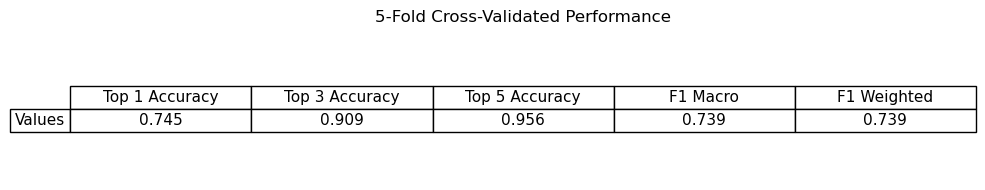

In [8]:
import matplotlib.pyplot as plt

# --- Build summary table with two thresholds ---
metrics_summary = {
    "Top 1 Accuracy": [
        metrics["Accuracy"],
    ],
    "Top 3 Accuracy": [
        metrics['Top_3'],
    ],
    "Top 5 Accuracy": [
        metrics["Top_5"],
    ],
    "F1 Macro": [
        metrics["f1_macro"],
    ],
    "F1 Weighted": [
        metrics["f1_weighted"],
    ]
}

column_labels = list(metrics_summary.keys())
row_labels = [f"Values"]

row_values = [
    [f"{v:.3f}" for v in values]
    for values in zip(*metrics_summary.values())
]

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')

# --- Create table ---
table = ax.table(
    cellText=row_values,
    rowLabels=row_labels,
    colLabels=column_labels,
    loc='center',
    cellLoc='center',
    rowLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

plt.title("5-Fold Cross-Validated Performance", fontsize=12, pad=12)
plt.tight_layout()
plt.show()


#### 5-Fold CV Confusion Matrix

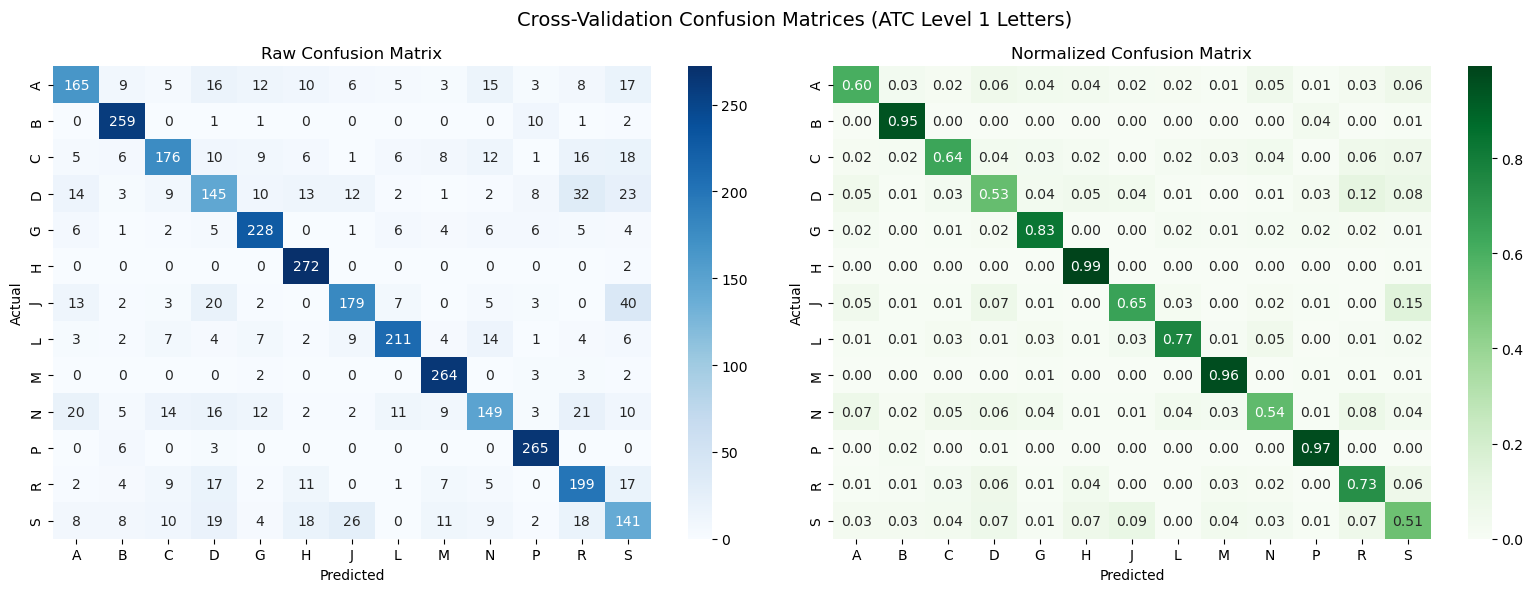

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# --- Load ATC mapping and extract just the letter ---
atc_map_df = pd.read_csv("Dataset/atc/dataset.csv")
label_mapping = atc_map_df.sort_values("atc_numeric")["atc_level1"].str[0].tolist()

# --- Confusion Matrices ---
cm_raw = confusion_matrix(y_ros, y_pred_cv)
cm_norm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]

# --- Plot side-by-side confusion matrices ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping, yticklabels=label_mapping, ax=axes[0])
axes[0].set_title("Raw Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=label_mapping, yticklabels=label_mapping, ax=axes[1])
axes[1].set_title("Normalized Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.suptitle("Cross-Validation Confusion Matrices (ATC Level 1 Letters)", fontsize=14)
plt.tight_layout()
plt.show()


### 💾 Exporting Model and Preprocessing Objects

To ensure consistent inference, we save all key components of the training pipeline:

These objects are exported using `joblib` and can later be reloaded to preprocess new SMILES-derived features and make predictions without retraining.


In [14]:
import joblib

# Save pipeline and threshold together as a dictionary
model_bundle = {
    "pipeline": pipeline_cv,
}

joblib.dump(model_bundle, 'Model/drugclass_logreg_bundle.pkl')

print("✅ Model bundle (pipeline) saved to 'Model/drugclass_logreg_bundle.pkl'")


✅ Model bundle (pipeline) saved to 'Model/drugclass_logreg_bundle.pkl'
